In [65]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

# PyTorch
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_mean_pool
import torch.nn.functional as F

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

# cust_functions folder
from cust_functions.training import *
from cust_functions.graph_networks import *
from cust_functions.graph_creation import *

In [27]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [2]:
# Load data
input_data = pd.read_csv("aki_data/test_data.tsv", sep="\t", )
input_data_qm = pd.read_csv("aki_data/test_qm.csv")
translation = pd.read_csv("aki_data/translation.tsv", sep="\t", index_col=0)
pathways = pd.read_csv("aki_data/pathways.tsv", sep="\t")
design_matrix = pd.read_csv("aki_data/design_matrix.tsv", sep="\t")

# Preprocess input data
input_data_preprocessed = input_data_qm.fillna(0)
design_matrix = design_matrix.replace(1, 0)
design_matrix = design_matrix.replace(2, 1)

In [3]:
# Initialize graph
G = create_pathway_graph(pathways, translation, descendants=True, delete_empty=False)

print("Number of nodes: ", len(G.nodes))
print("Number of edges: ", len(G.edges))
print("Number of nodes with no edges: ", len([n for n in G.nodes if G.degree(n)==0]))
print("Mean number of edges per node: ", np.round(np.mean([G.degree(n) for n in G.nodes]),1))
print("Max number of edges per node: ", np.max([G.degree(n) for n in G.nodes]))
print("Min number of edges per node: ", np.min([G.degree(n) for n in G.nodes]))
print("Median number of edges per node: ", np.median([G.degree(n) for n in G.nodes]))
print("Number of nodes without proteins: ", len([n for n in G.nodes if len(G.nodes[n].get('proteins', '') )==0]))


Number of nodes:  2585
Number of edges:  2603
Number of nodes with no edges:  0
Mean number of edges per node:  2.0
Max number of edges per node:  72
Min number of edges per node:  1
Median number of edges per node:  1.0
Number of nodes without proteins:  424


In [43]:
# Initialize validation
FOLDS = 3
train_labels = design_matrix['group'][design_matrix['sample'].str.contains('M2012')]
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

## 2.0 Model pipelines

### 2.1 Baseline model

In [4]:
train_graph_data, test_graph_data = [], []
patient_ids = design_matrix['sample'].values

for patient_id in patient_ids:
    graph = G.copy()

    # Add abundance to graph
    for _, row in input_data_preprocessed.iterrows():
        protein = row['Protein']  
        abundance = row[patient_id] 
        for pathway in graph.nodes:
            if 'proteins' in graph.nodes[pathway] and protein in graph.nodes[pathway]['proteins']:
                if 'abundance' not in graph.nodes[pathway]:
                    graph.nodes[pathway]['abundance'] = 0
                graph.nodes[pathway]['abundance'] += abundance
    
    # Convert NetworkX graph to PyTorch Geometric Data
    edge_index = map_edges_to_indices(graph.edges)
    x = torch.tensor([graph.nodes[node].get('abundance', 0) for node in graph.nodes], dtype=torch.float).unsqueeze(1)
    y = torch.tensor([design_matrix[design_matrix['sample'] == patient_id]['group'].iloc[0]], dtype=torch.long)
    graph_data = Data(x=x, edge_index=edge_index, y=y)

    if 'M2012' in patient_id:
        train_graph_data.append(graph_data)
    else:
        test_graph_data.append(graph_data)

In [56]:
print(f"Number of training graphs: {len(train_graph_data)}")
print(f"Number of test graphs: {len(test_graph_data)}")
print(f"Number of features: {train_graph_data[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data])}")
print(f"Is directed: {train_graph_data[0].is_directed()}")
print(train_graph_data[0])

Number of training graphs: 141
Number of test graphs: 56
Number of features: 1
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 1], edge_index=[2, 2603], y=[1])


In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.001
weight_decay = 0.00001
batch_size = 8
layer_configs = [
    {"in_channels": 128, "out_channels": 128, "dropout_rate": 0.3, "batch_norm": True, "residual": True},
    {"in_channels": 128, "out_channels": 64, "dropout_rate": 0.3, "batch_norm": True, "residual": True},
    {"in_channels": 64, "out_channels": 32, "dropout_rate": 0.3, "batch_norm": True, "residual": True},
]

loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 100

# Initialize results dictionary
results = {}


for fold, (train_idx, test_idx) in enumerate(skf.split(train_graph_data, train_labels)):
    
    # Initialize fold results
    print(f"Fold: {fold + 1}")
    train_loader = DataLoader([train_graph_data[i] for i in train_idx], batch_size=batch_size)
    val_loader = DataLoader([train_graph_data[i] for i in test_idx], batch_size=batch_size)

    # Initialize model
    model = ResGCN(train_graph_data[0].num_features, layer_configs, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5, verbose=True)

    # Initialize early stopping
    best_val_loss = np.inf
    best_roc_auc = 0
    best_model = None
    patience = 20
    

    for epoch in range(num_epochs):
        
        # Train and validate
        train_loss, train_confusion_matrix = train(train_loader, model, optimizer, loss_fn, device, update_confusion_matrix=True)
        val_loss, val_confusion_matrix = validate(val_loader, model, loss_fn, device, update_confusion_matrix=True)

        # update results
        results = update_results(results, fold, epoch, train_loss, train_confusion_matrix, val_loss, val_confusion_matrix)
        
        # Early stopping 
        if results[fold]['val_roc_auc'][-1] > best_roc_auc:
            best_roc_auc = results[fold]['val_roc_auc'][-1]
            best_val_epoch = epoch + 1
            best_model = model.state_dict().copy()
            patience = 15
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # print epoch results
        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {results[fold]['train_accuracy'][-1]:.4f}")
        print(f"Epoch: {epoch + 1}, Val Loss: {val_loss:.4f}, Val Acc: {results[fold]['val_accuracy'][-1]:.4f}, Val ROC_AUC: {results[fold]['val_roc_auc'][-1]:.4f}, Val F1 Phen1: {results[fold]['val_f1_phen1'][-1]:.4f}, Val F1 Phen2: {results[fold]['val_f1_phen2'][-1]:.4f}")

        # update learning rate
        scheduler.step(val_loss)
        
    # save best model for fold
    model.load_state_dict(best_model)
    PATH = f"trained_models/Baseline_model_fold_{fold + 1}_rocauc_{np.round(best_roc_auc, 2)}.pt"
    torch.save(model.state_dict(), PATH)


Using device: cuda
Fold: 1
Epoch: 1, Train Loss: 0.7440, Train Acc: 0.4894
Epoch: 1, Val Loss: 0.6908, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 2, Train Loss: 0.7265, Train Acc: 0.5319
Epoch: 2, Val Loss: 0.6899, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 3, Train Loss: 0.7325, Train Acc: 0.4681
Epoch: 3, Val Loss: 0.6884, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 4, Train Loss: 0.7145, Train Acc: 0.5000
Epoch: 4, Val Loss: 0.6880, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 5, Train Loss: 0.7091, Train Acc: 0.5532
Epoch: 5, Val Loss: 0.6923, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 6, Train Loss: 0.7022, Train Acc: 0.4362
Epoch: 6, Val Loss: 0.7015, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 7, Train Loss: 0.6984, T

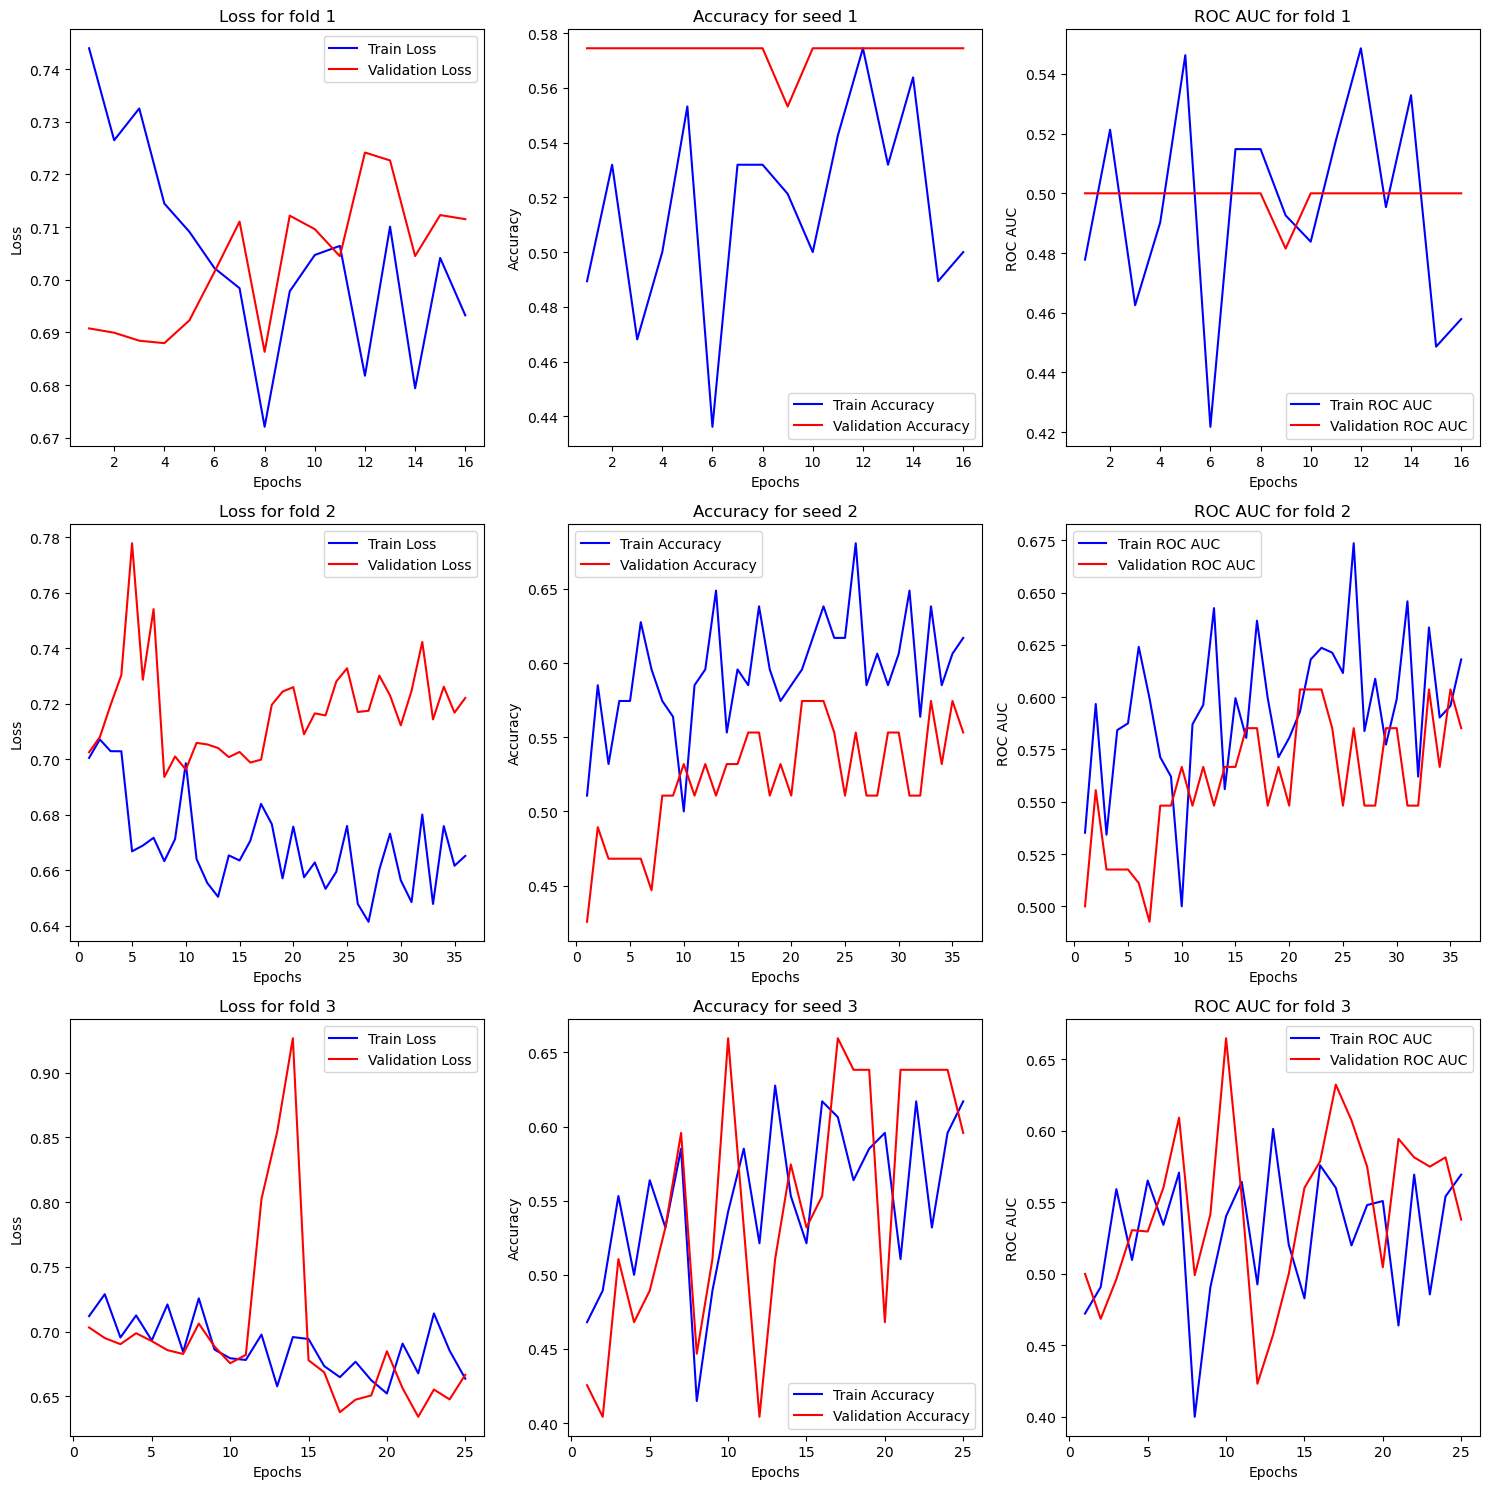

In [79]:
plot_results(results, FOLDS)